In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
from scipy import signal

In [2]:
%matplotlib inline

In [3]:
fly = flb.NetFly(1525,rootpath='/media/imager/FlyDataD/FlyDB/')
fly.open_signals()

In [4]:
abf_sp = fly.abf_times[1] #abf spike period
ca_frame_in_abf = np.int(0.02/abf_sp) #abf period in abf idxs

In [5]:
#get the idx's where the ca data is aquired
ep_idx = np.where(np.array(fly.abf_led_pulse)>1.0)[0]
start = ep_idx[0]+ca_frame_in_abf #the calcium data starts at the end of one trigger period 
stop = ep_idx[-1]

In [6]:
#make a time array for the recording epoch
ep_times = np.array(fly.abf_times[start:stop])
ep_times -= ep_times[0]

In [7]:
#load this into memory since I will use it quite a bit
spike_sig = np.array(fly.abf_electrode[start:stop])
b1_ca = fly.ca_camera_left_model_fits['b1']
## another way of extracting b1 activity
#F_ = np.mean(fly.ca_camera_left[:,24:34,75:100],axis = (1,2))
#F = np.percentile(F_,0.01)
#DF_F = (F_-F)/F
#put the ca data into the abf timebase
resampled_b1_ca,resampled_t = signal.resample(b1_ca,len(ep_times),
                                              np.array(fly.ca_camera_left_times))

In [8]:
#grab a spike pool
spike_idxs = util.idx_by_thresh(spike_sig,thresh = 1.0)
#filter out false positives here
#get_peaks
peak_idxs = [np.argmax(spike_sig[idx[0]-10:idx[-1]+10])+idx[0]-10 for idx in spike_idxs]

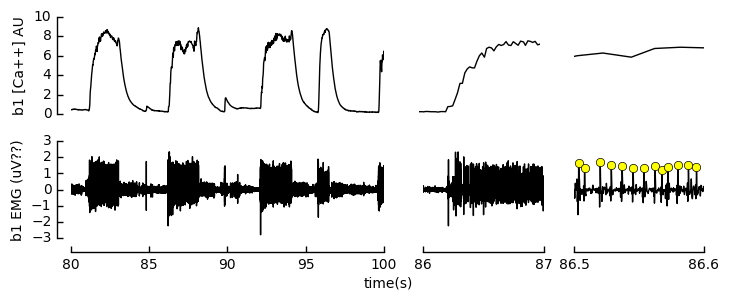

In [9]:
#inspect the data at a several time-scales
layout = fifi.FigureLayout('inspection_layout.svg',make_mplfigures = True)

layout.axes['ax1'].plot(fly.ca_camera_left_times,
                        fly.ca_camera_left_model_fits['b1'],color = 'k')
layout.axes['ax1'].set_xbound(80,100)
layout.axes['ax1'].set_ylabel('b1 [Ca++] AU')
layout.axes['ax2'].plot(ep_times,spike_sig,color = 'k')
layout.axes['ax2'].set_xbound(80,100)
#layout.axes['ax2'].set_ylabel('b1 EMG (%s)'%fly.abf_electrode_units[0])
layout.axes['ax2'].set_ylabel('b1 EMG (%s)'%'uV??')
#WE SHOULD FIGURE OUT WHAT THE UNITS ARE AND ADD IT TO THE AXON PROTOCOL

layout.axes['ax1_inset'].plot(fly.ca_camera_left_times,
                              fly.ca_camera_left_model_fits['b1'],color = 'k')
layout.axes['ax1_inset'].set_xbound(86,87)
layout.axes['ax1_inset'].set_xticks([86,87])

layout.axes['ax2_inset'].plot(ep_times,
                              spike_sig,color = 'k')
layout.axes['ax2_inset'].set_xbound(86,87)
layout.axes['ax2_inset'].set_xticks([86,87])

layout.axes['ax1_inset2'].plot(fly.ca_camera_left_times,
                               fly.ca_camera_left_model_fits['b1'],color = 'k')
layout.axes['ax1_inset2'].set_xbound(86.5,86.6)

layout.axes['ax2_inset2'].plot(ep_times,spike_sig,color = 'k')
layout.axes['ax2_inset2'].plot(ep_times[peak_idxs],
                               spike_sig[peak_idxs],'o',color = 'yellow')

layout.axes['ax2_inset2'].set_xbound(86.5,86.6)
layout.axes['ax2_inset2'].set_xticks([86.5,86.6])
layout.axes['ax2_inset2'].set_xticklabels(['86.5','86.6'])

layout.axes['time_label'].set_xlabel('time(s)')
layout.axes['time_label'].set_zorder(-10)
fifi.mpl_functions.set_spines(layout)
layout.save('spikes_vs_ca.svg')

In [10]:
#calculate spike frequency as a function of time
#I don't use this in the analysis, below but it is 
#a usefull metric to calculate
isi = np.zeros_like(spike_sig) #inter spike interval
previous_spk_time = 0
previous_spk_idx = 0
for spk_idx in peak_idxs:
    spk_time = ep_times[spk_idx]
    isi[previous_spk_idx:spk_idx] = spk_time-previous_spk_time
    previous_spk_time = spk_time
    previous_spk_idx = spk_idx
spike_frequency = 1./isi
spike_frequency[~np.isreal(spike_frequency)] = 0

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in divide


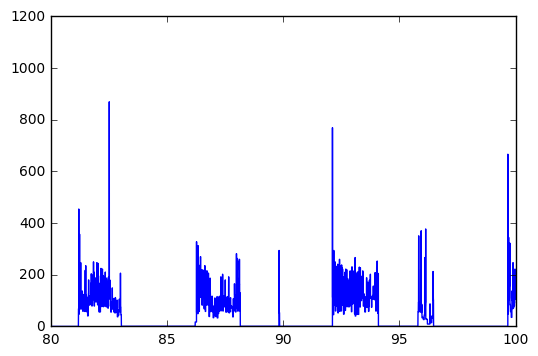

In [11]:
#probably want to filter this a bit.
plt.plot(ep_times,spike_frequency)
plt.gca().set_xbound(80,100)

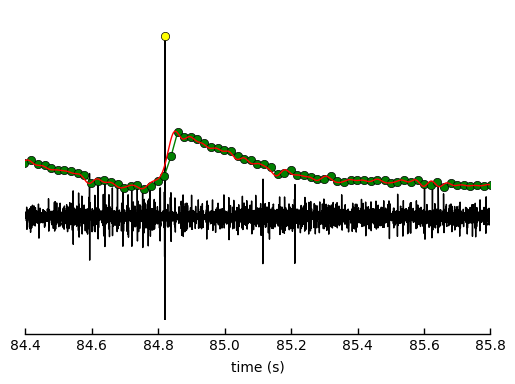

In [12]:
#check response to an isolated spike
plt.plot(ep_times,spike_sig,color = 'black')
#non-resampled ca_signal
plt.plot(fly.ca_camera_left_times,
         fly.ca_camera_left_model_fits['b1'],'-o',color = 'green')
#resampled ca signal... a little distortion but not too bat
plt.plot(ep_times,
         resampled_b1_ca,color = 'red')
#the single spike in this window
plt.plot(ep_times[peak_idxs],
         spike_sig[peak_idxs],'o',color = 'yellow')
plt.gca().set_xbound(84.6,85.8)
plt.gca().set_xlabel('time (s)')
plt.gca().set_ybound(-1,2.0)
fifi.mpl_functions.adjust_spines(plt.gca(),['bottom'])

In [13]:
#calculate kernel as spike triggered average
#for now include all spikes
filt_peak_idx = peak_idxs
KERNEL_DURATION = 60
# uncomment to filter using the isi so that you only inlude isolated spikes
#filt_peak_idx = [nxt_idx for spk_idx,nxt_idx in zip(peak_idxs[:-1],peak_idxs[1:]) if 
#(isi[spk_idx]>0.5) & (isi[nxt_idx]>0.01)] 
ca_chunks = [resampled_b1_ca[spk_idx:spk_idx+60000] for spk_idx in filt_peak_idx]

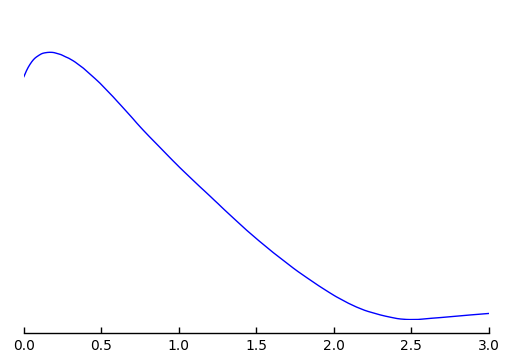

In [14]:
#looks a bit odd
kernel = np.mean(ca_chunks,axis = 0)
kernel -= np.min(kernel)
plt.plot(np.arange(60000)*abf_sp,kernel)
fifi.mpl_functions.adjust_spines(plt.gca(),['left','bottom'])
fifi.mpl_functions.adjust_spines(plt.gca(),['bottom'])

In [15]:
test_range = (80,100) 

In [16]:
#create an impulse train to represent the spikes
impulses = np.zeros_like(spike_sig)
impulses[peak_idxs] = 1

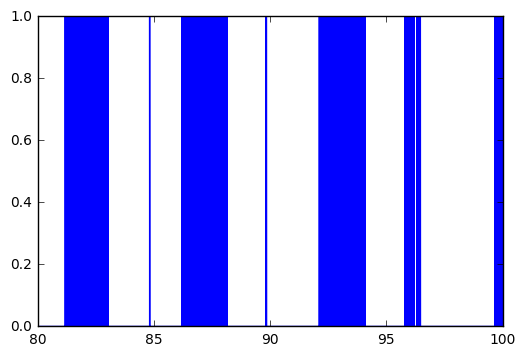

In [17]:
plt.plot(ep_times,impulses)
plt.gca().set_xbound(80,100)

In [18]:
#at 20KHz np.convolve is a bit slow
test_indxs = (ep_times>80) & (ep_times<100)

In [19]:
%timeit np_test = signal.convolve(impulses[test_indxs],kernel,mode = 'full')
np_test = signal.convolve(impulses[test_indxs],kernel,mode = 'full')

1 loop, best of 3: 29 s per loop


In [20]:
full_length_kernel = np.zeros((np.sum(test_indxs)))
full_length_kernel[:len(kernel)] = kernel

In [21]:
#much faster, problems with the ends of the trace but that 
#shouldn't be much of an issue as long as the records are 
#relatively long
%timeit direct_test = np.fft.ifft(np.fft.fft(impulses[test_indxs])*np.fft.fft(full_length_kernel))#,mode = 'full')
direct_test = np.fft.ifft(np.fft.fft(impulses[test_indxs])*np.fft.fft(full_length_kernel))#,mode = 'full')

1 loop, best of 3: 1.1 s per loop


/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


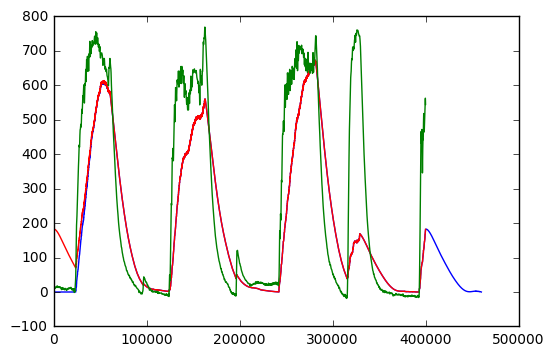

In [22]:
plt.plot(np_test,color = 'b')
plt.plot(direct_test,color = 'r')
plt.plot(resampled_b1_ca[test_indxs]*90-30,color = 'g')

In [23]:
#rather than use the spike triggered average,
#deconvolve in the frequency domain to get the kernel and use the whole sequence
kernel = np.real(np.fft.ifft(np.fft.fft(resampled_b1_ca)/np.fft.fft(impulses)))

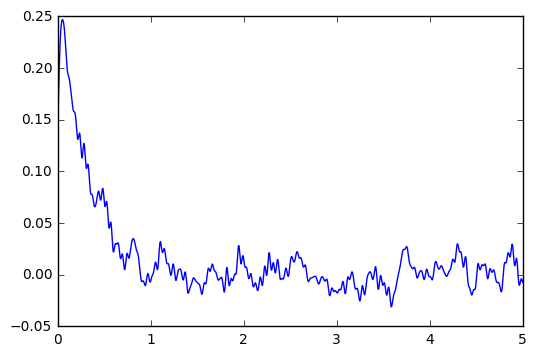

In [34]:
#Looks a bit better but, we still don't really capture the fastest components
#Might be a
plt.plot(ep_times,kernel)
plt.gca().set_xbound(0,5)

In [25]:
#I'm using a double exponential decay beacuse of the assumption that the 
#kernel arises from the sum of the gcamp and muscle dynamics
def make_kernel(times,tauon,tauoff,tauoff2):
    kx = np.copy(times)
    kon = lambda x:np.exp(((-1*tauon)/(x)))
    koff1 = lambda x:np.exp((-1*x)/tauoff)
    koff2 = lambda x:np.exp((-1*x)/tauoff2)
    k = (kon(kx)*koff1(kx)*koff2(kx)/np.max(kon(kx)*koff1(kx)*koff2(kx)))
    k = np.hstack(k)
    return k

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide


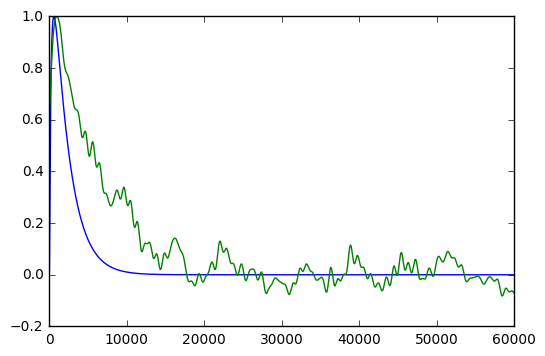

In [26]:
sp = 20. #sample period ms
MK_TON = 10/1000. #ms
MK_TOFF = 3000/1000. #ms
MK_TOFF2 = 100/1000.
plt.plot(make_kernel(ep_times[:60000],MK_TON,MK_TOFF,MK_TOFF2))
plt.plot(kernel[:60000]/np.max(kernel[:60000]))

In [27]:
#just fit to the first segment of the curve
short_kernel = kernel[:60000]/np.max(kernel[:60000])
from scipy.optimize import curve_fit
popt,pcov = curve_fit(make_kernel,
                      ep_times[:60000],
                      short_kernel,
                      [MK_TON,MK_TOFF,MK_TOFF2])

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide
/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


In [28]:
#negative TAU2 seems a bit off, but ~300ms for
#gcamp seems about correct perhaps this should be constrained to a 
#positive number or dropped from the fit.
popt

array([  2.65788506e-03,  -1.89499562e+02,   2.91291334e-01])

In [29]:
fit_kernel = make_kernel(ep_times,*popt) 

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide


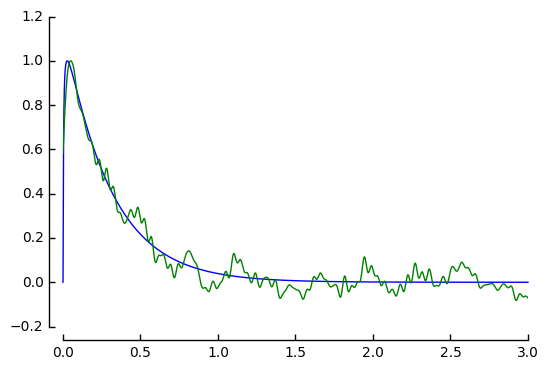

In [30]:
plt.plot(ep_times[:60000],fit_kernel[:60000],clip_on = False)
plt.plot(ep_times[:60000],short_kernel/np.max(short_kernel))
fifi.mpl_functions.adjust_spines(plt.gca(),['left','bottom'])

In [31]:
reconstruction = np.fft.ifft(np.fft.fft(impulses)*np.fft.fft(fit_kernel))

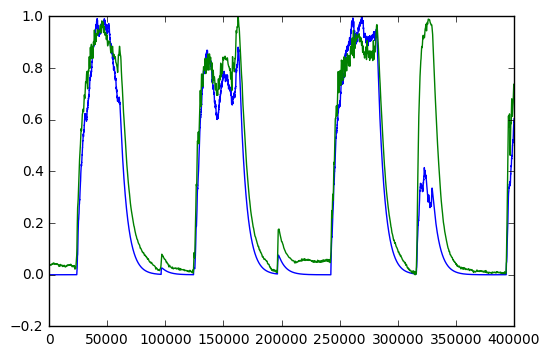

In [32]:
plt.plot(reconstruction[test_indxs]/np.max(reconstruction[test_indxs]))
sig = resampled_b1_ca[test_indxs]-np.min(resampled_b1_ca[test_indxs])
plt.plot(sig/np.max(sig))

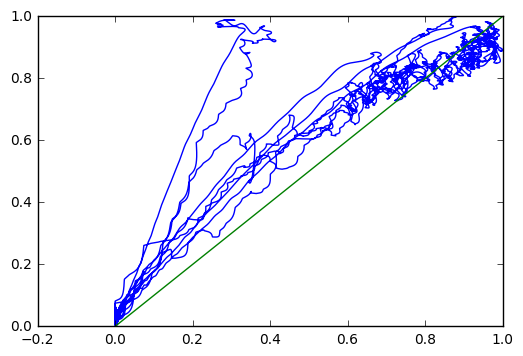

In [33]:
#it appears the gcamp response is not fully linear. This might come from
#a nonlinearity in muscle calcium cycling or the gcamp calcium binding properites.
plt.plot((reconstruction[test_indxs]/np.max(reconstruction[test_indxs])),
         (sig/np.max(sig)))
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))